In [3]:
!pip install openmeteo_requests


   ---------------------------------------- 3/3 [openmeteo_requests]



In [5]:
!pip install requests_cache


   ---------------------------------------- 3/3 [requests_cache]



In [7]:
!pip install retry_requests

In [10]:
!pip install tensorflow

  Using cached tensorflow-2.19.0-cp310-cp310-win_amd64.whl.metadata (4.1 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached protobuf-5.29.4-cp310-abi3-win_amd64.whl.metadata (592 bytes)
  Using cached termcolor-3.1.0-py3-none-any.whl.metadata (6.4 kB)
  Using cached keras-3.9.2-py3-none-any.whl.metadata (6.1 kB)
  Using cached h5py-3.13.0-cp310-cp310-win_amd64.whl.metadata (2.5 kB)
  Using cached ml_dtypes-0.5.1-cp310-cp310-win_amd64.whl.metadata (22 kB)
  Using cached tensorflow_io_gcs_filesystem-0.31.0-cp310-cp310-win_amd64.whl.metadata (14 kB)
  Using cached rich-14.0.0-py3-none-any.whl.metadata (18 kB)
  Using cached namex-0.0.9-py3-none-any.whl.metadata (322 bytes)
  Usin

In [51]:
import joblib
import torch 
import pandas as pd
import numpy as np
from metpy.calc import wind_components
from metpy.units import units
import openmeteo_requests
import requests_cache
from math import radians, sin, cos, sqrt, atan2
from torch.utils.data import Dataset, DataLoader
from transformers import PatchTSTForPrediction, PatchTSTConfig
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import joblib 
import matplotlib.pyplot as plt
from darts import TimeSeries
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import os
import datetime as dt
import pytz
from retry_requests import retry
from datetime import timedelta, datetime

import torch.nn as nn
from tensorflow.keras.models import load_model
from tsfm_public import (
    TimeSeriesForecastingPipeline,
    TinyTimeMixerForPrediction,
)

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# API

In [34]:
def get_ordered_hourly_variables(params):
    return params.get("hourly", [])

#setting up API client
cache_session = requests_cache.CachedSession('.cache', expire_after=3600)
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
openmeteo = openmeteo_requests.Client(session=retry_session)


#Sample use
# df = get_reading("https://api.open-meteo.com/v1/forecast",
#             31.990534, 35.907787,
#             ["temperature_2m", "dew_point_2m", "relative_humidity_2m",
#            "pressure_msl", "wind_speed_10m", "wind_direction_10m"], 5,
#             0)

def get_reading(url, latitude, longtitute, hourly, past_days, future_days):
    params = {
        "latitude": latitude,
        "longitude": longtitute,
        "hourly": hourly,
        "past_days": past_days,
        "forecast_days": future_days
    }

    response = openmeteo.weather_api(url, params=params)[0]
    hourly = response.Hourly()

    # Convert from UTC to UTC+3
    start_time = pd.to_datetime(hourly.Time(), unit="s", utc=True) + pd.Timedelta(hours=3)
    end_time = pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True) + pd.Timedelta(hours=3)

    hourly_data = {
        "date": pd.date_range(
            start=start_time,
            end=end_time,
            freq=pd.Timedelta(seconds=hourly.Interval()),
            inclusive="left"
        )
    }

    for i, var_name in enumerate(get_ordered_hourly_variables(params)):
        hourly_data[var_name] = hourly.Variables(i).ValuesAsNumpy()

    hourly_df = pd.DataFrame(data=hourly_data)
    hourly_df['Date/Time'] = pd.to_datetime(hourly_df['date'], errors='coerce')
    hourly_df.set_index('Date/Time', inplace=True)
    hourly_df.drop(columns=['date'], inplace=True)


    hourly_df.rename(columns={
        "dew_point_2m": "Air Dew Point",
        "temperature_2m": "Air Temperature (OC)",
        "relative_humidity_2m": "Humidity %",
        "pressure_msl": "Atmospheric Pressure",
        "wind_speed_10m": "Wind Speed (MPS)",
        "wind_direction_10m": "Wind Direction (Degrees)"
    }, inplace=True)

    hourly_df.index = hourly_df.index.tz_convert(None)

    u, v = wind_components(
        hourly_df['Wind Speed (MPS)'].values * units('m/s'),
        hourly_df['Wind Direction (Degrees)'].values * units.degree
    )

    hourly_df['Wind_U'] = u.magnitude  
    hourly_df['Wind_V'] = v.magnitude
    hourly_df.Wind_U = hourly_df.Wind_U.round(2)
    hourly_df.Wind_V = hourly_df.Wind_V.round(2)

    hourly_df.drop(columns=["Wind Speed (MPS)", "Wind Direction (Degrees)"], inplace=True)
    hourly_df = hourly_df[['Air Dew Point', 'Air Temperature (OC)', 'Humidity %', 'Atmospheric Pressure', 'Wind_U', 'Wind_V']]
    
    return hourly_df

In [35]:
# sample use
# get_realtime_5days("https://api.open-meteo.com/v1/forecast",
#             31.990534, 35.907787,
#             ["temperature_2m", "dew_point_2m", "relative_humidity_2m",
#            "pressure_msl", "wind_speed_10m", "wind_direction_10m"])
def get_realtime_512hours(api_url, latitude, longitude, variables):
    """
    Fetches the latest 512 hours of weather data up to the current time using get_reading().

    Parameters:
    - api_url: URL of the weather API
    - latitude: float, location latitude
    - longitude: float, location longitude
    - variables: list of weather variables to fetch
    - timezone_offset_hours: int, for formatting timestamps correctly
    - gmt_offset: int, offset from UTC in hours (e.g., 0 for GMT, 3 for GMT+3)

    Returns:
    - DataFrame with last 512 hourly weather records up to current time
    """
    # Calculate the full time window: 23 days past + 1 day future = 24 days
    now_utc = datetime.utcnow()
    start_date = now_utc - timedelta(days=23)
    end_date = now_utc + timedelta(days=1)


    # Call get_reading() with computed dates
    df = get_reading(
        api_url,
        latitude,
        longitude,
        variables,
        23,
        1
    )

    # Ensure datetime index
    df.index = pd.to_datetime(df.index)

    # Filter last 512 hours up to now (adjusting for local time)
    now_local = datetime.utcnow()
    df = df[df.index <= now_local].tail(512)

    return df

In [36]:
test = get_realtime_512hours("https://api.open-meteo.com/v1/forecast",
            31.990534, 35.907787,
            ["temperature_2m", "dew_point_2m", "relative_humidity_2m",
           "pressure_msl", "wind_speed_10m", "wind_direction_10m"])

In [37]:
len(test)

512

In [38]:
test.tail()

,Air Dew Point,Air Temperature (OC),Humidity %,Atmospheric Pressure,Wind_U,Wind_V
Date/Time,,,,,,
2025-05-17 13:00:00,-1.348666,34.740002,10.0,1015.000000,-1.44,11.52
2025-05-17 14:00:00,-0.478537,35.890003,10.0,1014.599976,3.96,8.64
2025-05-17 15:00:00,1.066987,36.190002,11.0,1014.099976,10.44,4.68
2025-05-17 16:00:00,0.723003,35.740002,11.0,1013.799988,14.04,1.44
2025-05-17 17:00:00,1.395304,35.040001,12.0,1013.099976,13.32,-0.00


# TTM-R2

In [39]:
test_df["Unnamed: 0"] = test_df.index

NameError: name 'test_df' is not defined

In [83]:
# import os
# import torch
# import joblib


# # Constants
# target_columns = ["Air Dew Point", "Air Temperature (OC)", "Humidity %", "Atmospheric Pressure", "Wind_U", "Wind_V"]
# context_length = 512
# prediction_length = 96
# station = 'amman'

# # Paths
# BASE_DIR = f'TTM Model/{station.replace(" ", "_")}/eval'
# CHECKPOINT_PATH = os.path.join(BASE_DIR, "output", "checkpoint-14715")  # Fine-tuned checkpoint
# PREPROCESSOR_PATH = os.path.join(BASE_DIR, "trained_preprocessor.joblib")

# # Load preprocessor
# tsp = joblib.load(PREPROCESSOR_PATH)

# # Load fine-tuned model from checkpoint
# model = TinyTimeMixerForPrediction.from_pretrained(CHECKPOINT_PATH)

# # Create inference pipeline
# inference_pipeline = TimeSeriesForecastingPipeline(
#     model=model,
#     device="cuda" if torch.cuda.is_available() else "cpu",
#     feature_extractor=tsp,
#     batch_size=512,
#     freq="h"  # Hourly frequency, matches your data
# )

# # Inference
# forecast_df = inference_pipeline(test_df)
# print(forecast_df.head())

In [84]:
# prediction_columns = [col for col in forecast_df.columns if col.endswith('_prediction')]

# # Extract the prediction data
# predictions = {col.replace('_prediction', ''): forecast_df[col].iloc[0] for col in prediction_columns}

# # Generate hourly timestamps for the prediction horizon
# start_time = pd.to_datetime(test_df["Unnamed: 0"].iloc[-1]) + pd.Timedelta(hours=1)
# prediction_index = pd.date_range(start=start_time, periods=96, freq="h")

# # Create a tidy DataFrame
# forecast_output = pd.DataFrame(predictions, index=prediction_index)
# forecast_output.index.name = "datetime"

# Functions

In [40]:

def reconstruct_wind_speed_direction(df):
    """
    Given a DataFrame with Wind_U and Wind_V columns,
    returns two new columns: Wind Speed (MPS) and Wind Direction (Degrees)
    """
    df = df.copy()
    
    # Compute wind speed
    df['Wind Speed (MPS)'] = np.sqrt(df['Wind_U']**2 + df['Wind_V']**2)
    
    # Compute wind direction in meteorological convention:
    # direction from which wind is blowing (0 = North, 90 = East, 180 = South, etc.)
    df['Wind Direction (Degrees)'] = (270 - np.degrees(np.arctan2(df['Wind_V'], df['Wind_U']))) % 360

    return df

In [41]:
class RainLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2):
        super(RainLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()  
        )

    def forward(self, x):
        _, (hn, _) = self.lstm(x) 
        return self.fc(hn[-1])  

In [42]:
#distance fucntion
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat / 2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon / 2)**2
    return R * 2 * atan2(sqrt(a), sqrt(1 - a))

In [43]:
def get_nearest_station(location):
    names = ['aqaba', 'ghor', 'irbid', 'irwaished', 'maan', 'mafraq', 'amman', 'safawi']
 
    coordinates = [            # (latitude, longitude)
    (29.5500, 35.0000),    # Aqabah
    (31.0333, 35.4667),    # Ghor
    (32.5500, 35.8500),    # Irbid
    (32.5000, 38.2000),    # Irwaished
    (30.1667, 35.7833),    # Maan
    (32.3667, 36.2500),    # Mafraq
    (31.7167, 35.9833),    # Amman
    (32.1608, 37.1539),    # Safawi
    ]
    lat, lon = location
    distances = []
    for stat_lat, stat_lon in coordinates:
        distances.append(haversine(lat, lon, stat_lat, stat_lon))
    closest_idx = int(np.argmin(distances))
    return names[closest_idx]

In [44]:

"""
This function takes a 48 hours of input features :'Air Dew Point', 'Air Temperature (OC)', 'Humidity %',
'Atmospheric Pressure', 'Cloud Cover %', 'Wind_U', 'Wind_V', location (latitude, longtitude) and models and transformers directory,
returns closest station name and a single rain probability for next 12 hours
"""
def predict_rain_probability(location, df_48h, models_dir="Models/Precipitation_Models"):
    
    input_features = [
    'Air Dew Point', 'Air Temperature (OC)', 'Humidity %',
    'Atmospheric Pressure', 'Cloud Cover %', 'Wind_U', 'Wind_V',
    'hour_sin', 'hour_cos', 'day_sin', 'day_cos'
    ]
    
    #Find closest station
    station = get_nearest_station(location)

    #Load model and scaler
    scaler = joblib.load(f"{models_dir}/{station}_scaler.pkl")
    model = RainLSTM(input_size=11)
    model.load_state_dict(torch.load(f"{models_dir}/{station}_precipitation_model.pth", map_location=torch.device('cpu')))
    model.eval()

    #preprocessing 
    df = df_48h.copy()
    df['hour'] = df['time'].dt.hour
    df['day_yr'] = df['time'].dt.dayofyear
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['day_sin'] = np.sin(2 * np.pi * df['day_yr'] / 365)
    df['day_cos'] = np.cos(2 * np.pi * df['day_yr'] / 365)

    df[input_features] = scaler.transform(df[input_features])
    input_data = df[input_features].values.astype(np.float32)

    #Padding just in case
    if len(input_data) < 48:
        pad_len = 48 - len(input_data)
        padding = np.repeat(input_data[-1:], pad_len, axis=0)
        input_data = np.vstack([input_data, padding])

    input_tensor = torch.tensor(input_data).unsqueeze(0)  #shape (1, 48, 11)

    with torch.no_grad():
        prob = model(input_tensor).item()

    return {
        "closest_station": station,
        "precipitation_probability": round(prob, 4)
    }

In [45]:
"""
This function takes a 48 hours of input features :'Air Dew Point', 'Air Temperature (OC)', 'Humidity %',
'Atmospheric Pressure', 'Cloud Cover %', 'Wind_U', 'Wind_V', location (latitude, longtitude) and models and transformers directory,
returns cloud cover for next 24 hour time stamps
"""

def predict_cloud_cover(location, df_48h):
    names = ['aqaba', 'ghor', 'irbid', 'irwaished', 'maan', 'mafraq', 'amman', 'safawi']
    coordinates = [
        (29.5500, 35.0000), (31.0333, 35.4667), (32.5500, 35.8500), (32.5000, 38.2000),
        (30.1667, 35.7833), (32.3667, 36.2500), (31.7167, 35.9833), (32.1608, 37.1539),
    ]
    
    station = get_nearest_station(location)
    input_scaler = joblib.load(f"Models/Cloud_Cover_Models/{station}_input_scaler.save")
    target_scaler = joblib.load(f"Models/Cloud_Cover_Models/{station}_target_scaler.save")
    model = load_model(f"Models/Cloud_Cover_Models/{station}_cloud_model.keras")

    #Preprocess input dataframe
    df = df_48h.copy()
   

    df['hour'] = df['time'].dt.hour
    df['month'] = df['time'].dt.month
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

    input_features = ['Air Dew Point', 'Air Temperature (OC)', 'Humidity %',
                      'Atmospheric Pressure', 'Wind_U', 'Wind_V']
    X_input = input_scaler.transform(df[input_features])
    X_input = np.expand_dims(X_input, axis=0)  # Shape: (1, 48, 6)

    y_pred_scaled = model.predict(X_input)
    y_pred = target_scaler.inverse_transform(y_pred_scaled)
    
    return y_pred.flatten()  # Shape: (24,)

In [46]:
def Cloud_and_Precipitation(df_120h, location):
    all_cloud_preds = []
    #Predict cloud first
    for step in [0, 24, 48, 72, 96]:
        df_window = df_120h.iloc[step:step + 48].copy()
        cloud_preds = predict_cloud_cover(location, df_window)  
        all_cloud_preds.extend(cloud_preds)


    assert len(all_cloud_preds) == 120, f"Expected 120 cloud preds, got {len(all_cloud_preds)}"


    df_with_cloud = df_120h.copy()
    df_with_cloud['Cloud Cover %'] = 0.0  # ensure float type
    cloud_col_index = df_with_cloud.columns.get_loc('Cloud Cover %')


    df_with_cloud.iloc[-120:, cloud_col_index] = all_cloud_preds

    #predict rain probs
    rain_probs = [] 

    for step in range(0, 109, 12):  # steps: 0, 12, ..., 72
        df_window = df_with_cloud.iloc[step:step + 48].copy()
        prob = predict_rain_probability(location, df_window)["precipitation_probability"]
        rain_probs.append(prob)

    
    day_night_tuples = [
        (rain_probs[i], rain_probs[i + 1]) for i in range(0, len(rain_probs), 2)
    ]

    return {
        "cloud_cover": all_cloud_preds,           #120 values (5x24h)
        "rain_probabilities": day_night_tuples    #5 tuples (day, night)
    }

In [57]:
def predict_TTM(df_512, station):
    # Constants
    target_columns = ["Air Dew Point", "Air Temperature (OC)", "Humidity %", 
                      "Atmospheric Pressure", "Wind_U", "Wind_V"]
    context_length = 512
    prediction_length = 96
    df_512["Unnamed: 0"] = df_512.index

    # Paths
    BASE_DIR = f'TTM Model/{station.replace(" ", "_")}/eval'
    checkpoint_dir = next(d for d in os.listdir(os.path.join(BASE_DIR, "output")) if d.startswith("checkpoint-"))
    CHECKPOINT_PATH = os.path.join(BASE_DIR, "output", checkpoint_dir)
    PREPROCESSOR_PATH = os.path.join(BASE_DIR, "trained_preprocessor.joblib")

    # Load preprocessor and model
    tsp = joblib.load(PREPROCESSOR_PATH)
    model = TinyTimeMixerForPrediction.from_pretrained(CHECKPOINT_PATH)

    # Create inference pipeline
    inference_pipeline = TimeSeriesForecastingPipeline(
        model=model,
        device="cuda" if torch.cuda.is_available() else "cpu",
        feature_extractor=tsp,
        batch_size=512,
        freq="h"
    )

    # ---- First prediction (96h) ----
    forecast_df1 = inference_pipeline(df_512)
    prediction_columns = [col for col in forecast_df1.columns if col.endswith('_prediction')]
    predictions1 = {col.replace('_prediction', ''): forecast_df1[col].iloc[0] for col in prediction_columns}
    start_time = pd.to_datetime(df_512["Unnamed: 0"].iloc[-1]) + pd.Timedelta(hours=1)
    prediction_index1 = pd.date_range(start=start_time, periods=96, freq="h")
    forecast_output1 = pd.DataFrame(predictions1, index=prediction_index1)

    # ---- Second prediction (24h) ----
    # Extend the input with the first prediction to get the next 24h
    df_extended = pd.concat([df_512[target_columns], forecast_output1], axis=0)
    df_extended = df_extended.iloc[-512:]
    df_extended["Unnamed: 0"] = df_extended.index

    forecast_df2 = inference_pipeline(df_extended)
    predictions2 = {col.replace('_prediction', ''): forecast_df2[col].iloc[0][:24] for col in prediction_columns}
    prediction_index2 = pd.date_range(start=prediction_index1[-1] + pd.Timedelta(hours=1), periods=24, freq="h")
    forecast_output2 = pd.DataFrame(predictions2, index=prediction_index2)

    # Combine both
    final_forecast = pd.concat([forecast_output1, forecast_output2])
    final_forecast.index.name = "datetime"

    return final_forecast

In [48]:
len(predict_TTM(test, 'amman'))

NameError: name 'TinyTimeMixerForPrediction' is not defined

# Predict full forecast

In [49]:
def predict_full_forecast(location: tuple):
    station = get_nearest_station(location)

    # past_data = get_reading("https://api.open-meteo.com/v1/forecast",
    #         location[0], location[1],
    #         ["temperature_2m", "dew_point_2m", "relative_humidity_2m",
    #        "pressure_msl", "wind_speed_10m", "wind_direction_10m"], 4,
    #         0)
    past_data = get_realtime_512hours("https://api.open-meteo.com/v1/forecast",
            location[0], location[1],
            ["temperature_2m", "dew_point_2m", "relative_humidity_2m",
           "pressure_msl", "wind_speed_10m", "wind_direction_10m"])
    # past_data = past_data.tail(72)
    TTM_preds = predict_TTM(past_data, station)
    input_with_time = TTM_preds.copy()
    input_with_time['time'] = TTM_preds.index
    cloud_precipitation = Cloud_and_Precipitation(input_with_time.tail(120),location)

    time_series_outputs = TTM_preds
    time_series_outputs['Cloud Cover %'] = cloud_precipitation['cloud_cover']

    final_df = reconstruct_wind_speed_direction(time_series_outputs)
    final_df.drop(['Wind_U', 'Wind_V'], axis = 1, inplace = True)
    forecast = {
        "time_series" : final_df,
        'rain_probabilities' : cloud_precipitation['rain_probabilities']
    }
    
    return forecast

In [58]:
hh = predict_full_forecast((31.990534, 35.907787))

Device set to use cuda


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


C:\Users\20210291\AppData\Local\Temp\ipykernel_7148\3789347823.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"{models_dir}/{station}

In [53]:
hh['time_series']

,Air Dew Point,Air Temperature (OC),Humidity %,Atmospheric Pressure,Cloud Cover %,Wind Speed (MPS),Wind Direction (Degrees)
datetime,,,,,,,
2025-05-17 18:00:00,3.413394,32.027579,17.515019,1013.474004,9.850831,11.842587,291.535307
2025-05-17 19:00:00,2.074525,30.739105,15.499560,1013.305927,13.092736,8.042935,281.656232
2025-05-17 20:00:00,1.666456,29.203122,16.374516,1013.540779,8.426256,4.849832,278.517011
2025-05-17 21:00:00,1.448914,27.587220,18.902690,1013.885064,10.689709,2.631058,263.840571
2025-05-17 22:00:00,1.334590,26.129009,21.715531,1014.222086,9.520297,2.011678,230.885181
...,...,...,...,...,...,...,...
2025-05-22 13:00:00,5.148766,27.303823,27.081464,1011.913628,10.888924,13.705687,264.322917
2025-05-22 14:00:00,4.810560,27.437137,26.467352,1011.880642,13.624654,15.320192,268.206076
2025-05-22 15:00:00,4.599280,27.537888,25.806946,1011.695031,12.479011,16.776924,272.871619


In [54]:
hh['rain_probabilities']

[(0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0)]

In [55]:
def plot_each_column(df: pd.DataFrame, title_prefix: str = ""):
    """
    Plots each numerical column in the DataFrame on a separate subplot.

    Parameters:
    - df: DataFrame with datetime index and multiple numerical columns.
    - title_prefix: Optional prefix for subplot titles.
    """
    num_cols = df.select_dtypes(include='number').columns
    n = len(num_cols)

    if n == 0:
        print("No numerical columns to plot.")
        return

    # Create subplots
    fig, axes = plt.subplots(n, 1, figsize=(12, 3 * n), sharex=True)
    if n == 1:
        axes = [axes]  # Ensure axes is iterable

    for i, col in enumerate(num_cols):
        axes[i].plot(df.index, df[col], label=col)
        axes[i].set_title(f"{title_prefix}{col}")
        axes[i].set_ylabel(col)
        axes[i].grid(True)
        axes[i].legend()

    axes[-1].set_xlabel("Time")
    plt.tight_layout()
    plt.show()

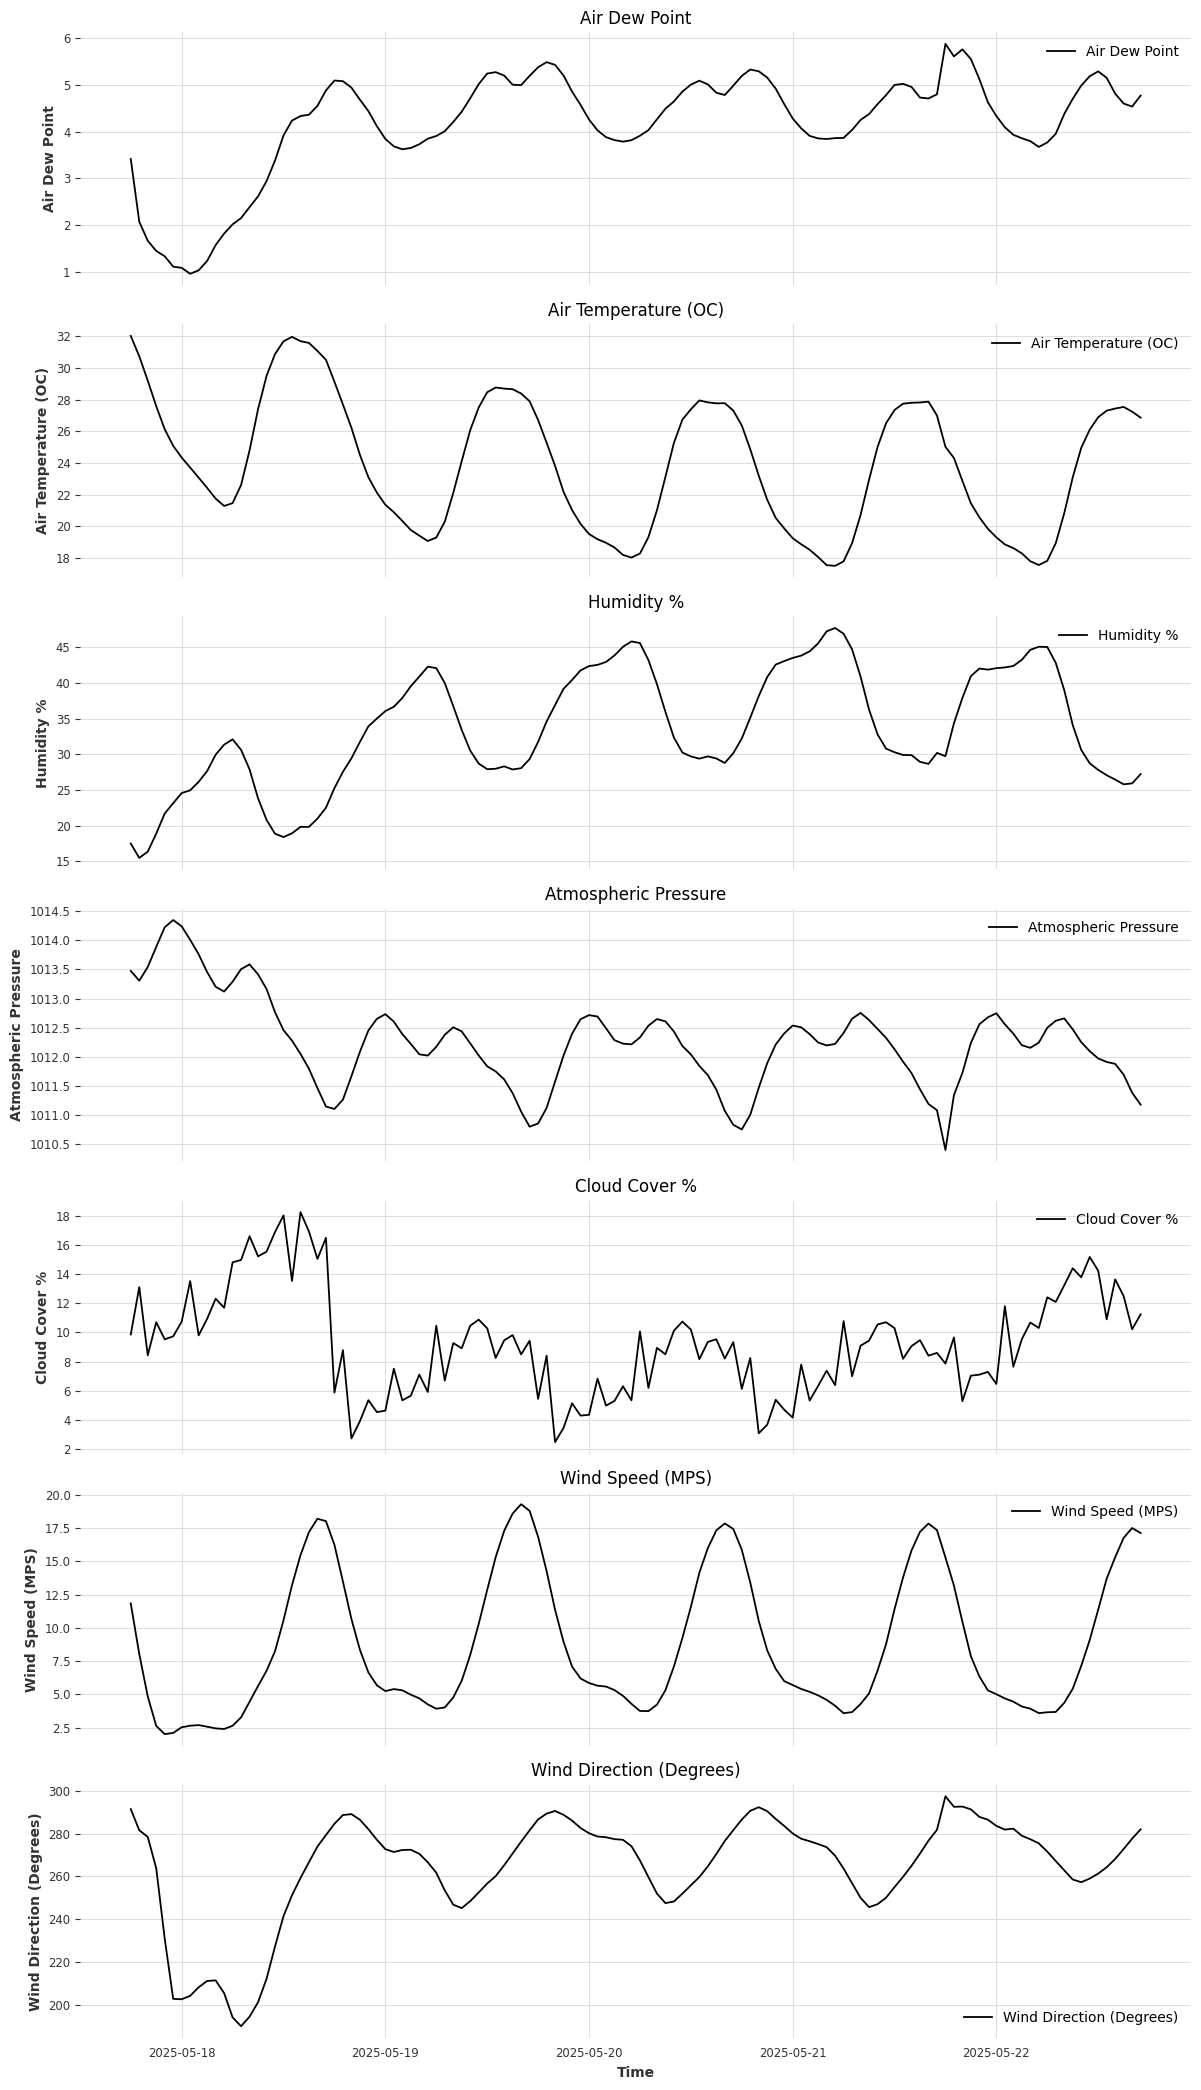

In [59]:
plot_each_column(hh['time_series'])

In [60]:
!pip install streamlit

   ---------------------------------------- 0.0/9.9 MB ? eta -:--:--
   --- ------------------------------------ 0.8/9.9 MB 6.7 MB/s eta 0:00:02
   ------------------------ --------------- 6.0/9.9 MB 20.5 MB/s eta 0:00:01
   ----------------------------- ---------- 7.3/9.9 MB 15.6 MB/s eta 0:00:01
   ------------------------------- -------- 7.9/9.9 MB 11.6 MB/s eta 0:00:01
   ----------------------------------- ---- 8.7/9.9 MB 9.9 MB/s eta 0:00:01
   -------------------------------------- - 9.4/9.9 MB 8.8 MB/s eta 0:00:01
   ---------------------------------------- 9.9/9.9 MB 7.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/731.2 kB ? eta -:--:--
   --------------------------------------- 731.2/731.2 kB 15.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/6.9 MB ? eta -:--:--
   ---------------------- ----------------- 3.9/6.9 MB 23.5 MB/s eta 0:00:01
   ---------------------------------- ----- 6.0/6.9 MB 14.2 MB/s eta 0:00:01
   -------------------